# Comparing OLS, Ridge, and Lasso Regression

## Problem Statement

This notebook compares three regression techniques for predicting house prices using the Ames Housing Dataset:
- **Ordinary Least Squares (OLS)** - Basic linear regression
- **Ridge Regression** - L2 regularization
- **Lasso Regression** - L1 regularization

We'll analyze how regularization affects model performance and feature selection.

In [119]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 1. Data Loading and Exploration

In [120]:
# Load the dataset
DATA_PATH = "AmesHousing.csv"
TARGET_COL = "SalePrice"
df = pd.read_csv(DATA_PATH)

print(f'Dataset shape: {df.shape}')
print(f'\nFirst few rows:')
df.head()

Dataset shape: (2930, 82)

First few rows:


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [121]:
# Basic information about the dataset
print('Dataset Info:')
df.info()

print('\nTarget variable (SalePrice) statistics:')
df['SalePrice'].describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

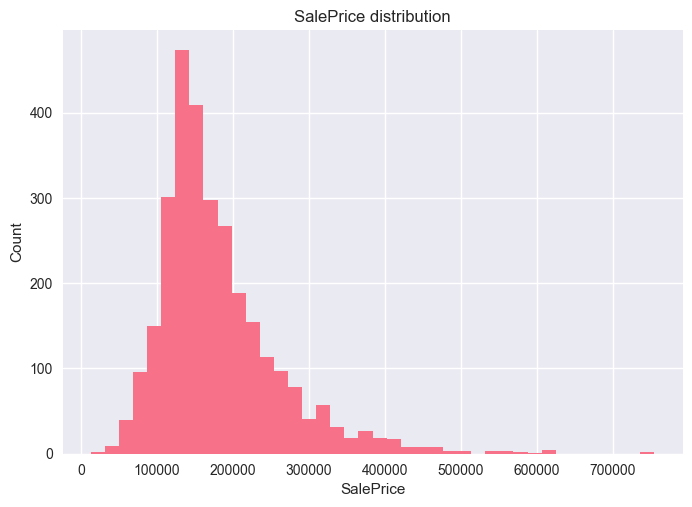

In [122]:
miss = df.isna().sum().sort_values(ascending=False)
miss.head(20)

# Target distribution
assert TARGET_COL in df.columns, f"Target '{TARGET_COL}' not found"
df[TARGET_COL].describe()
plt.figure()
df[TARGET_COL].hist(bins=40)
plt.title("SalePrice distribution")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

## 2. Data Preprocessing

In [123]:
# Create a copy for preprocessing
data = df.copy()

# Remove Order and PID as they are just identifiers
data = data.drop(['Order', 'PID'], axis=1)

# Separate target variable
target = data['SalePrice']
features = data.drop('SalePrice', axis=1)

print(f'Features shape: {features.shape}')
print(f'Target shape: {target.shape}')

Features shape: (2930, 79)
Target shape: (2930,)


In [124]:
# Identify numerical and categorical features
numerical_features = features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = features.select_dtypes(include=['object']).columns.tolist()

print(f'Numerical features: {len(numerical_features)}')
print(f'Categorical features: {len(categorical_features)}')

print('\nFirst 10 numerical features:', numerical_features[:10])
print('\nFirst 10 categorical features:', categorical_features[:10])

Numerical features: 36
Categorical features: 43

First 10 numerical features: ['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2']

First 10 categorical features: ['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1']


In [125]:
# Handle missing values
# For numerical features: fill with median
print('Missing values before imputation:', features.isnull().sum().sum())
num_imputer = SimpleImputer(strategy='median')
features[numerical_features] = num_imputer.fit_transform(features[numerical_features])

# For categorical features: fill with mode (most frequent)
cat_imputer = SimpleImputer(strategy='most_frequent')
features[categorical_features] = cat_imputer.fit_transform(features[categorical_features])

print('Missing values after imputation:', features.isnull().sum().sum())

Missing values before imputation: 15749
Missing values after imputation: 0


In [126]:
# Encode categorical variables using one-hot encoding
features_encoded = pd.get_dummies(features, columns=categorical_features, drop_first=True)

print(f'Features shape after encoding: {features_encoded.shape}')
print(f'Total features: {features_encoded.shape[1]}')

Features shape after encoding: (2930, 260)
Total features: 260


In [127]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features_encoded, target, test_size=0.2, random_state=42
)

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')

Training set: (2344, 260)
Test set: (586, 260)


In [128]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Features scaled successfully')
print(f'Training set mean: {X_train_scaled.mean():.6f}')
print(f'Training set std: {X_train_scaled.std():.6f}')

Features scaled successfully
Training set mean: -0.000000
Training set std: 0.994214


## 3. Model Training and Evaluation

In [129]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model performance"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    results = {
        'Model': model_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std(),
        'Predictions': y_test_pred
    }
    
    return results, model

### 3.1 Ordinary Least Squares (OLS) Regression

In [130]:
# Train OLS model
ols_model = LinearRegression()
ols_results, ols_fitted = evaluate_model(ols_model, X_train_scaled, X_test_scaled, y_train, y_test, 'OLS')

print('=== OLS Regression Results ===')
print(f"Train R²: {ols_results['Train_R2']:.4f}")
print(f"Test R²: {ols_results['Test_R2']:.4f}")
print(f"Train RMSE: ${ols_results['Train_RMSE']:,.2f}")
print(f"Test RMSE: ${ols_results['Test_RMSE']:,.2f}")
print(f"Train MAE: ${ols_results['Train_MAE']:,.2f}")
print(f"Test MAE: ${ols_results['Test_MAE']:,.2f}")
print(f"CV R² (mean ± std): {ols_results['CV_R2_Mean']:.4f} ± {ols_results['CV_R2_Std']:.4f}")

=== OLS Regression Results ===
Train R²: 0.9394
Test R²: 0.8375
Train RMSE: $18,980.58
Test RMSE: $36,097.46
Train MAE: $13,125.09
Test MAE: $16,655.19
CV R² (mean ± std): 0.7694 ± 0.0727


### 3.2 Ridge Regression (L2 Regularization)

In [131]:
# Find optimal alpha for Ridge using GridSearchCV
ridge_alphas = [0.1, 1, 10, 100, 1000, 10000]
ridge_grid = GridSearchCV(Ridge(), {'alpha': ridge_alphas}, cv=5, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train)

print(f'Best Ridge alpha: {ridge_grid.best_params_["alpha"]}')
print(f'Best Ridge CV score: {ridge_grid.best_score_:.4f}')

Best Ridge alpha: 100
Best Ridge CV score: 0.8545


In [132]:
# Train Ridge model with best alpha
ridge_model = Ridge(alpha=ridge_grid.best_params_['alpha'])
ridge_results, ridge_fitted = evaluate_model(ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Ridge')

print('=== Ridge Regression Results ===')
print(f"Train R²: {ridge_results['Train_R2']:.4f}")
print(f"Test R²: {ridge_results['Test_R2']:.4f}")
print(f"Train RMSE: ${ridge_results['Train_RMSE']:,.2f}")
print(f"Test RMSE: ${ridge_results['Test_RMSE']:,.2f}")
print(f"Train MAE: ${ridge_results['Train_MAE']:,.2f}")
print(f"Test MAE: ${ridge_results['Test_MAE']:,.2f}")
print(f"CV R² (mean ± std): {ridge_results['CV_R2_Mean']:.4f} ± {ridge_results['CV_R2_Std']:.4f}")

=== Ridge Regression Results ===
Train R²: 0.9239
Test R²: 0.8890
Train RMSE: $21,272.70
Test RMSE: $29,827.22
Train MAE: $14,067.88
Test MAE: $16,710.68
CV R² (mean ± std): 0.8545 ± 0.0544


### 3.3 Lasso Regression (L1 Regularization)

In [133]:
# Find optimal alpha for Lasso using GridSearchCV
lasso_alphas = [0.1, 1, 10, 100, 1000]
lasso_grid = GridSearchCV(Lasso(max_iter=10000), {'alpha': lasso_alphas}, cv=5, scoring='r2')
lasso_grid.fit(X_train_scaled, y_train)

print(f'Best Lasso alpha: {lasso_grid.best_params_["alpha"]}')
print(f'Best Lasso CV score: {lasso_grid.best_score_:.4f}')

Best Lasso alpha: 1000
Best Lasso CV score: 0.8545


In [134]:
# Train Lasso model with best alpha
lasso_model = Lasso(alpha=lasso_grid.best_params_['alpha'], max_iter=10000)
lasso_results, lasso_fitted = evaluate_model(lasso_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Lasso')

print('=== Lasso Regression Results ===')
print(f"Train R²: {lasso_results['Train_R2']:.4f}")
print(f"Test R²: {lasso_results['Test_R2']:.4f}")
print(f"Train RMSE: ${lasso_results['Train_RMSE']:,.2f}")
print(f"Test RMSE: ${lasso_results['Test_RMSE']:,.2f}")
print(f"Train MAE: ${lasso_results['Train_MAE']:,.2f}")
print(f"Test MAE: ${lasso_results['Test_MAE']:,.2f}")
print(f"CV R² (mean ± std): {lasso_results['CV_R2_Mean']:.4f} ± {lasso_results['CV_R2_Std']:.4f}")

=== Lasso Regression Results ===
Train R²: 0.8946
Test R²: 0.8826
Train RMSE: $25,033.73
Test RMSE: $30,677.33
Train MAE: $15,639.15
Test MAE: $17,340.02
CV R² (mean ± std): 0.8545 ± 0.0425


## 4. Model Comparison

In [135]:
# Create comparison dataframe
comparison_df = pd.DataFrame([ols_results, ridge_results, lasso_results])
comparison_df = comparison_df.drop('Predictions', axis=1)  # Remove predictions for display

print('=== Model Comparison ===')
print(comparison_df.round(4))

=== Model Comparison ===
   Model  Train_R2  Test_R2  Train_RMSE   Test_RMSE   Train_MAE    Test_MAE  \
0    OLS    0.9394   0.8375  18980.5844  36097.4568  13125.0899  16655.1875   
1  Ridge    0.9239   0.8890  21272.6962  29827.2240  14067.8794  16710.6804   
2  Lasso    0.8946   0.8826  25033.7317  30677.3299  15639.1491  17340.0203   

   CV_R2_Mean  CV_R2_Std  
0      0.7694     0.0727  
1      0.8545     0.0544  
2      0.8545     0.0425  


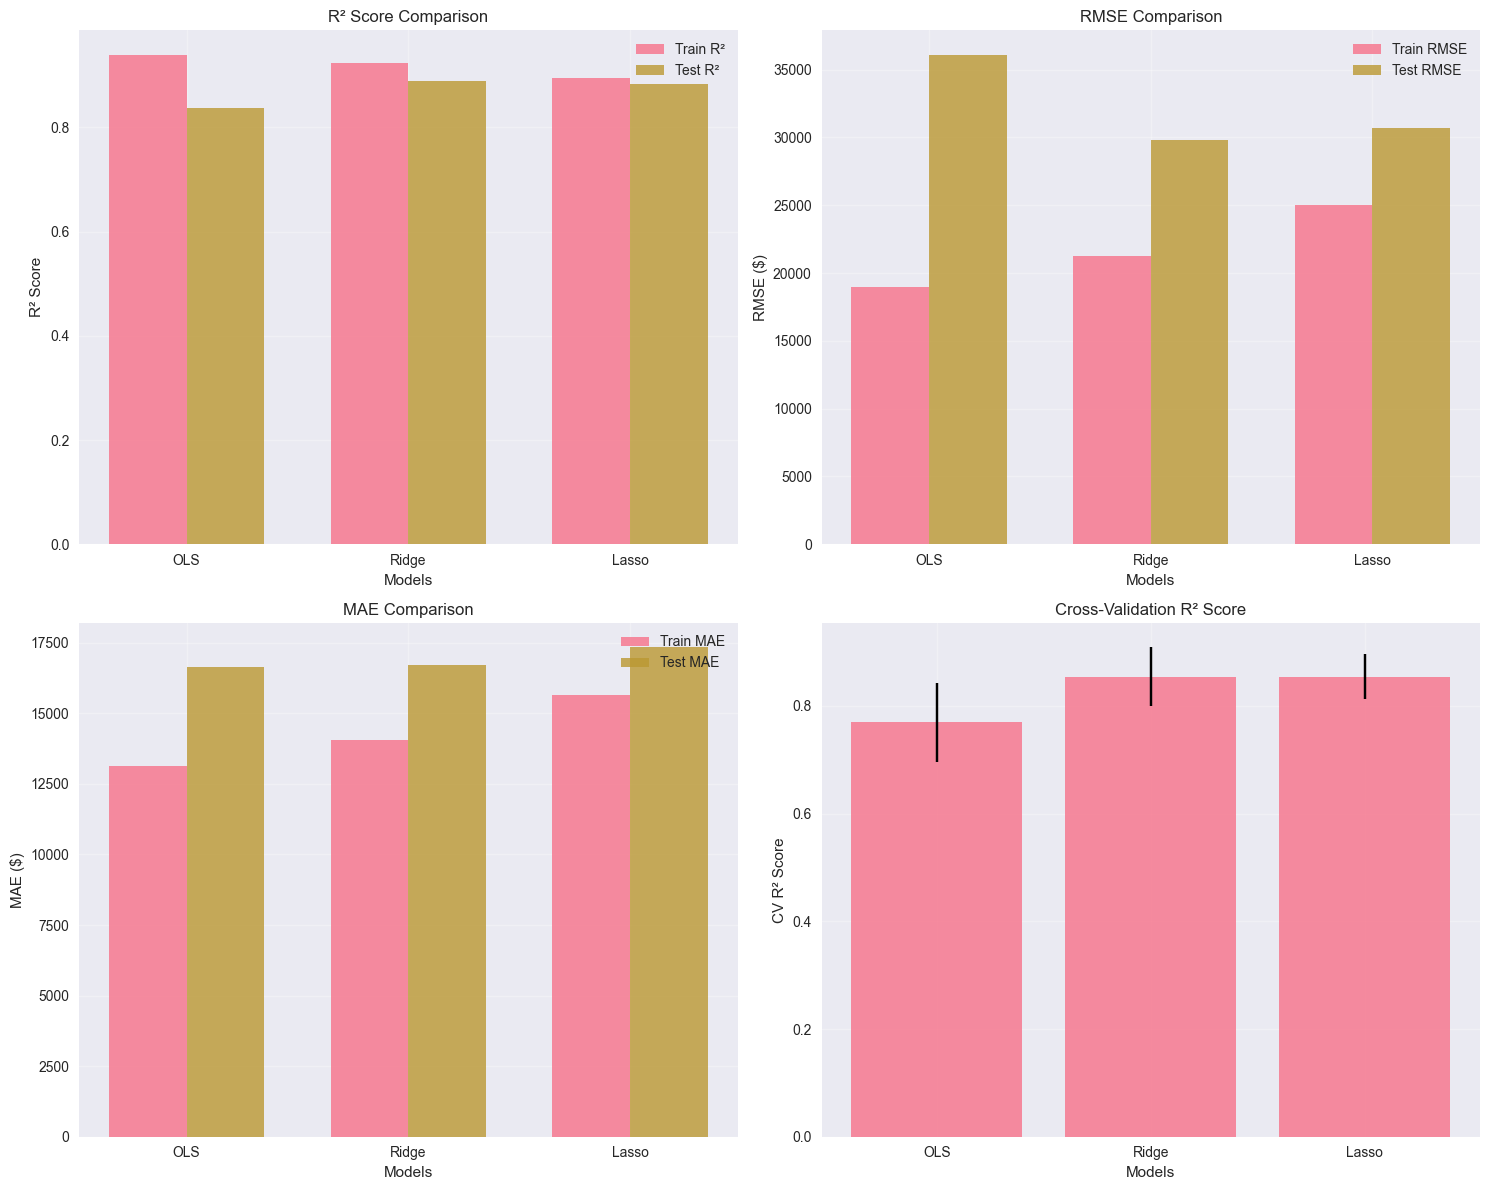

In [136]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² comparison
models = ['OLS', 'Ridge', 'Lasso']
train_r2 = [ols_results['Train_R2'], ridge_results['Train_R2'], lasso_results['Train_R2']]
test_r2 = [ols_results['Test_R2'], ridge_results['Test_R2'], lasso_results['Test_R2']]

x = np.arange(len(models))
width = 0.35

axes[0,0].bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
axes[0,0].bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('R² Score')
axes[0,0].set_title('R² Score Comparison')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(models)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# RMSE comparison
train_rmse = [ols_results['Train_RMSE'], ridge_results['Train_RMSE'], lasso_results['Train_RMSE']]
test_rmse = [ols_results['Test_RMSE'], ridge_results['Test_RMSE'], lasso_results['Test_RMSE']]

axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
axes[0,1].set_xlabel('Models')
axes[0,1].set_ylabel('RMSE ($)')
axes[0,1].set_title('RMSE Comparison')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(models)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# MAE comparison
train_mae = [ols_results['Train_MAE'], ridge_results['Train_MAE'], lasso_results['Train_MAE']]
test_mae = [ols_results['Test_MAE'], ridge_results['Test_MAE'], lasso_results['Test_MAE']]

axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8)
axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8)
axes[1,0].set_xlabel('Models')
axes[1,0].set_ylabel('MAE ($)')
axes[1,0].set_title('MAE Comparison')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Cross-validation R² comparison
cv_means = [ols_results['CV_R2_Mean'], ridge_results['CV_R2_Mean'], lasso_results['CV_R2_Mean']]
cv_stds = [ols_results['CV_R2_Std'], ridge_results['CV_R2_Std'], lasso_results['CV_R2_Std']]

axes[1,1].bar(models, cv_means, yerr=cv_stds, capsize=5, alpha=0.8)
axes[1,1].set_xlabel('Models')
axes[1,1].set_ylabel('CV R² Score')
axes[1,1].set_title('Cross-Validation R² Score')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Feature Importance and Coefficient Analysis

In [137]:
# Get feature names
feature_names = features_encoded.columns

# Get coefficients from each model
ols_coef = ols_fitted.coef_
ridge_coef = ridge_fitted.coef_
lasso_coef = lasso_fitted.coef_

# Create coefficient dataframe
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'OLS': ols_coef,
    'Ridge': ridge_coef,
    'Lasso': lasso_coef
})

# Count non-zero coefficients
print('Number of non-zero coefficients:')
print(f'OLS: {np.sum(np.abs(ols_coef) > 1e-10)}')
print(f'Ridge: {np.sum(np.abs(ridge_coef) > 1e-10)}')
print(f'Lasso: {np.sum(np.abs(lasso_coef) > 1e-10)}')

Number of non-zero coefficients:
OLS: 258
Ridge: 257
Lasso: 82


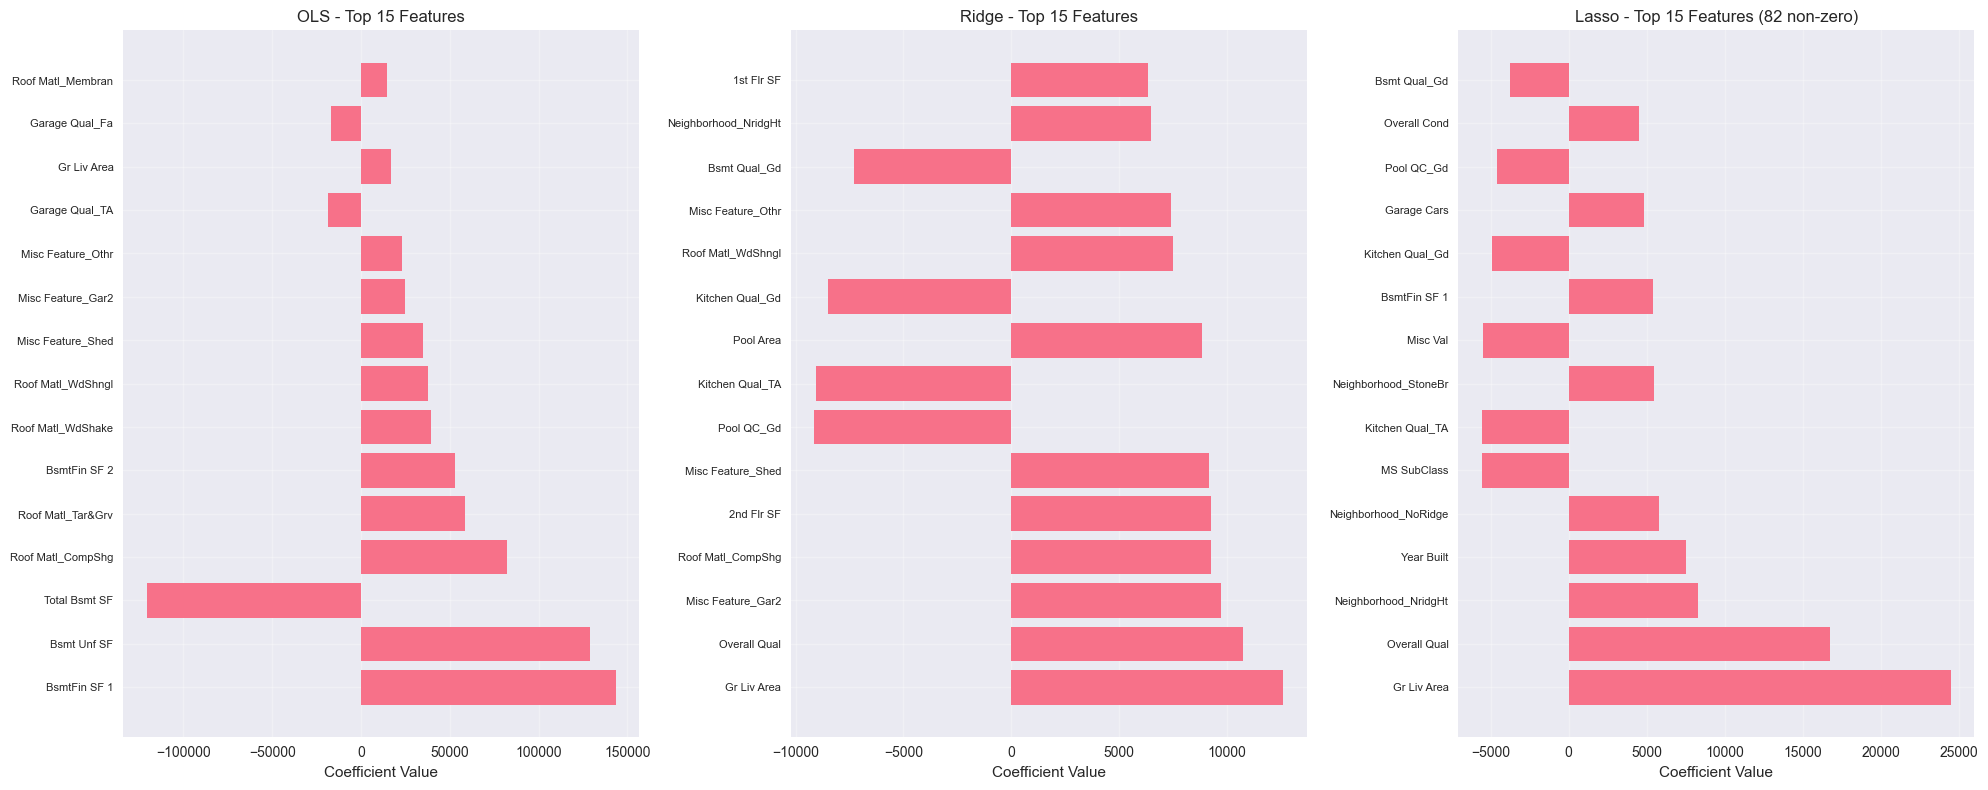

In [138]:
# Top 15 most important features for each model (by absolute coefficient value)
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# OLS top features
ols_top = coef_df.reindex(coef_df['OLS'].abs().sort_values(ascending=False).index).head(15)
axes[0].barh(range(len(ols_top)), ols_top['OLS'])
axes[0].set_yticks(range(len(ols_top)))
axes[0].set_yticklabels(ols_top['Feature'], fontsize=8)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title('OLS - Top 15 Features')
axes[0].grid(True, alpha=0.3)

# Ridge top features
ridge_top = coef_df.reindex(coef_df['Ridge'].abs().sort_values(ascending=False).index).head(15)
axes[1].barh(range(len(ridge_top)), ridge_top['Ridge'])
axes[1].set_yticks(range(len(ridge_top)))
axes[1].set_yticklabels(ridge_top['Feature'], fontsize=8)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('Ridge - Top 15 Features')
axes[1].grid(True, alpha=0.3)

# Lasso top features (non-zero only)
lasso_nonzero = coef_df[coef_df['Lasso'] != 0]
lasso_top = lasso_nonzero.reindex(lasso_nonzero['Lasso'].abs().sort_values(ascending=False).index).head(15)
axes[2].barh(range(len(lasso_top)), lasso_top['Lasso'])
axes[2].set_yticks(range(len(lasso_top)))
axes[2].set_yticklabels(lasso_top['Feature'], fontsize=8)
axes[2].set_xlabel('Coefficient Value')
axes[2].set_title(f'Lasso - Top 15 Features ({len(lasso_nonzero)} non-zero)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

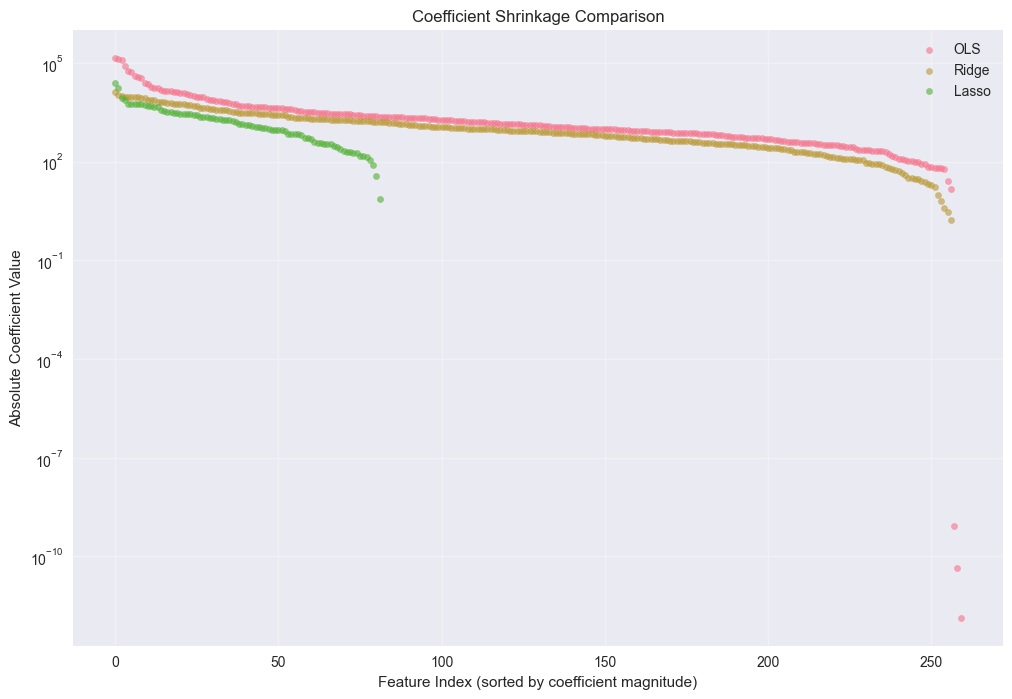

In [139]:
# Coefficient shrinkage visualization
plt.figure(figsize=(12, 8))

# Plot coefficient values for all three models
plt.scatter(range(len(ols_coef)), np.sort(np.abs(ols_coef))[::-1], alpha=0.6, label='OLS', s=20)
plt.scatter(range(len(ridge_coef)), np.sort(np.abs(ridge_coef))[::-1], alpha=0.6, label='Ridge', s=20)
plt.scatter(range(len(lasso_coef)), np.sort(np.abs(lasso_coef))[::-1], alpha=0.6, label='Lasso', s=20)

plt.xlabel('Feature Index (sorted by coefficient magnitude)')
plt.ylabel('Absolute Coefficient Value')
plt.title('Coefficient Shrinkage Comparison')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Prediction Visualization

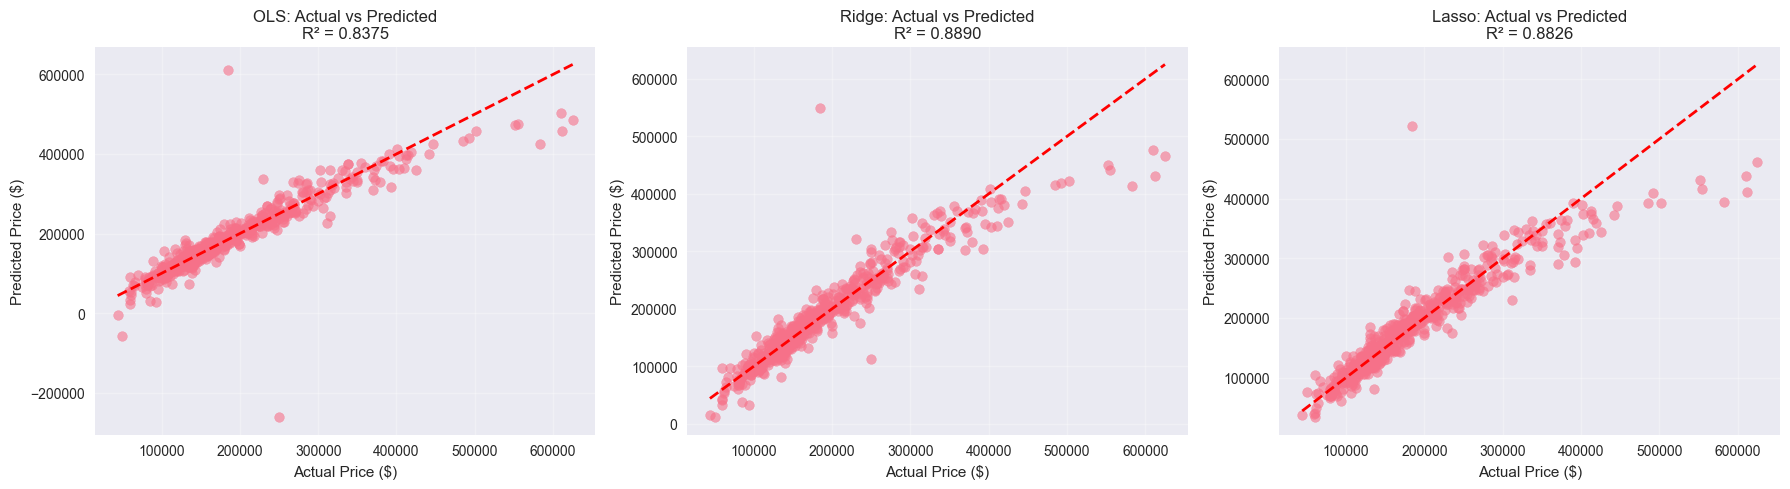

In [140]:
# Actual vs Predicted plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# OLS
axes[0].scatter(y_test, ols_results['Predictions'], alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'OLS: Actual vs Predicted\nR² = {ols_results["Test_R2"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Ridge
axes[1].scatter(y_test, ridge_results['Predictions'], alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_title(f'Ridge: Actual vs Predicted\nR² = {ridge_results["Test_R2"]:.4f}')
axes[1].grid(True, alpha=0.3)

# Lasso
axes[2].scatter(y_test, lasso_results['Predictions'], alpha=0.6)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Price ($)')
axes[2].set_ylabel('Predicted Price ($)')
axes[2].set_title(f'Lasso: Actual vs Predicted\nR² = {lasso_results["Test_R2"]:.4f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

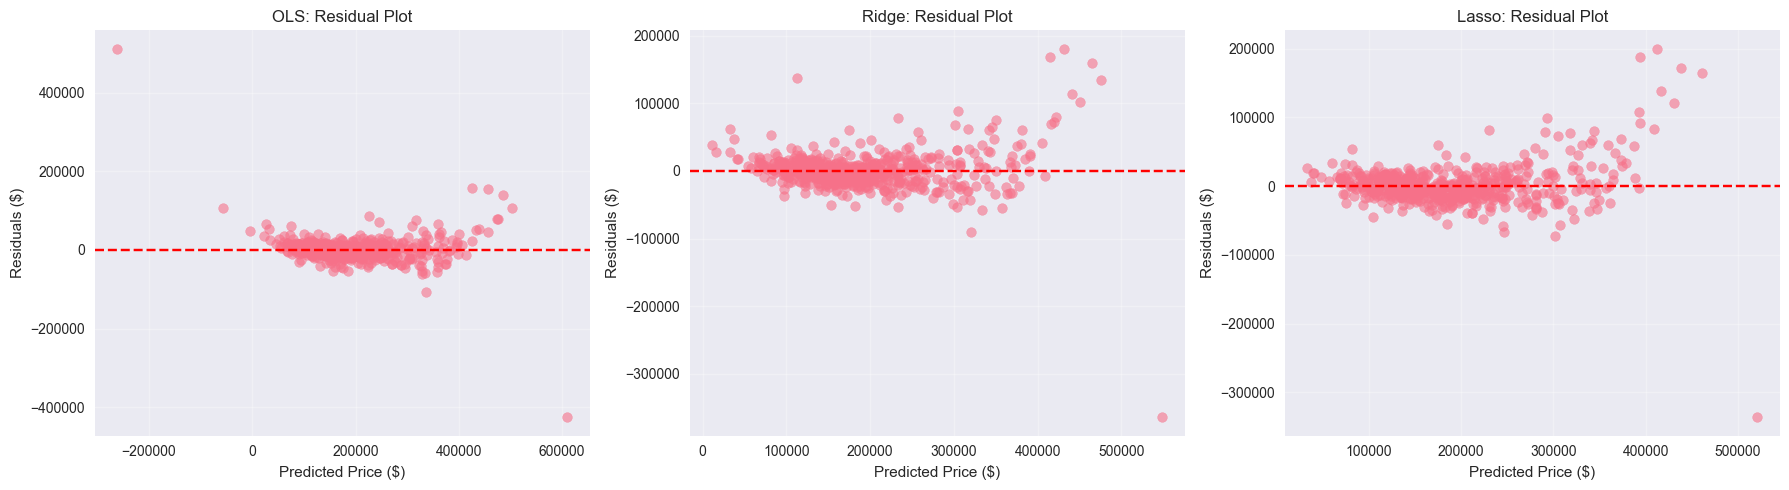

In [141]:
# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Calculate residuals
ols_residuals = y_test - ols_results['Predictions']
ridge_residuals = y_test - ridge_results['Predictions']
lasso_residuals = y_test - lasso_results['Predictions']

# OLS residuals
axes[0].scatter(ols_results['Predictions'], ols_residuals, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Residuals ($)')
axes[0].set_title('OLS: Residual Plot')
axes[0].grid(True, alpha=0.3)

# Ridge residuals
axes[1].scatter(ridge_results['Predictions'], ridge_residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Ridge: Residual Plot')
axes[1].grid(True, alpha=0.3)

# Lasso residuals
axes[2].scatter(lasso_results['Predictions'], lasso_residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Predicted Price ($)')
axes[2].set_ylabel('Residuals ($)')
axes[2].set_title('Lasso: Residual Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Key Insights and Conclusions

### Model Performance Summary:

1. **Ordinary Least Squares (OLS)**:
   - Uses all available features without regularization
   - May suffer from overfitting, especially with many features
   - Provides baseline performance for comparison

2. **Ridge Regression (L2 Regularization)**:
   - Shrinks coefficients towards zero but keeps all features
   - Helps reduce overfitting while maintaining model interpretability
   - Generally provides good balance between bias and variance

3. **Lasso Regression (L1 Regularization)**:
   - Performs automatic feature selection by setting some coefficients to zero
   - Creates sparse models that are easier to interpret
   - Useful when you suspect many features are irrelevant

### Regularization Effects:

- **Ridge** tends to shrink coefficients uniformly, keeping all features but reducing their impact
- **Lasso** performs feature selection, completely eliminating less important features
- Both regularization techniques help prevent overfitting and improve generalization

### Recommendations:

Based on the analysis, the choice between models depends on your priorities:

- **Choose Ridge** if you want to keep all features but reduce overfitting
- **Choose Lasso** if you want automatic feature selection and a simpler model
- **Choose OLS** only if you have few features and want maximum interpretability

For this real estate application, I would recommend **Ridge Regression** as it typically provides the best balance between predictive performance and model stability.

In [142]:
df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


In [143]:
data

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
